<a href="https://colab.research.google.com/github/yskim5892/AI_Expert_2022/blob/main/Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST
from torchvision.transforms import Compose,ToTensor

from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import PIL

### GAN
#### Generator
- Generates fake images
- Get labels to generates specific images

In [2]:
class Generator(nn.Module):
    def __init__(self,latent_size):
        super(Generator,self).__init__()
        self.latent_size = latent_size

        self.gen_fc1 = nn.Linear(self.latent_size,128)
        self.label_fc = nn.Linear(10,128)
        self.gen_fc2 = nn.Linear(256,512)
        self.gen_fc3 = nn.Linear(512,784)

    def generator(self,label):
        batch_size = label.shape[0]
        z = torch.randn((batch_size,self.latent_size))
        if torch.cuda.is_available():
            z = z.cuda()

        gen = self.gen_fc1(z)
        gen_label = self.label_fc(label)
        gen = torch.cat((gen,gen_label),-1)
        gen = torch.relu(gen)
        gen = self.gen_fc2(gen)
        gen = torch.relu(gen)
        gen = self.gen_fc3(gen)
        img_ = torch.sigmoid(gen).view(-1,1,28,28)
        return img_

    def forward(self,label):
        img = self.generator(label)
        return img

#### Discriminator
- Find fake images

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()

        self.dis_fc1 = nn.Linear(784,512)
        self.dis_fc2 = nn.Linear(512,128)
        self.label_fc = nn.Linear(10,128)
        self.dis_fc3 = nn.Linear(256,32)
        self.dis_fc4 = nn.Linear(32,1)

    def discriminator(self,img,label):
        batch_size = img.shape[0]
        img = img.view(batch_size,-1)

        dis = self.dis_fc1(img)
        dis = torch.relu(dis)
        dis = self.dis_fc2(dis)
        dis = torch.relu(dis)
        dis_label = self.label_fc(label)
        dis = torch.cat((dis,dis_label),-1)
        dis = self.dis_fc3(dis)
        dis = torch.relu(dis)
        dis = self.dis_fc4(dis)
        dis = torch.sigmoid(dis)
        return dis

    def forward(self,img,label):
        criterion = self.discriminator(img,label)
        return criterion

#### Util functions

In [4]:
def one_hot(x):
    res = torch.zeros((x.shape[0],10))
    for i in range(x.shape[0]):
        res[i,x[i]]=1
    return res

#### Hyperparameters

In [5]:
NUM_EPOCHS = 150
BATCH_SIZE = 128
LATENT_SIZE = 100
LEARNING_RATE = 2e-4
EPS = 1e-6
LEARNING_RATIO = 1

#### Dataloader

In [6]:
transforms = Compose([
    ToTensor(),
])

trainset = MNIST('./',train=True,transform=transforms,download=True)
testset = MNIST('./',train=False,transform=transforms,download=True)

args = {
    'num_workers' : 1,
    'batch_size' : BATCH_SIZE,
    'shuffle' : True,
}

train_loader = DataLoader(trainset,**args)
test_loader = DataLoader(testset,**args)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



#### Training part

number of parameters(generator) : 548112
number of parameters(discriminator) : 477249
epoch 1
 gen : 1593.09963	 dis : 203.24120


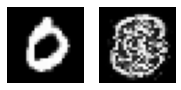

KeyboardInterrupt: ignored

In [7]:
gen = Generator(LATENT_SIZE)
dis = Discriminator()
if torch.cuda.is_available():
    gen = gen.cuda()
    dis = dis.cuda()

gen_parameters = filter(lambda p: p.requires_grad, gen.parameters())
num_params = sum([np.prod(p.size()) for p in gen_parameters])
print("number of parameters(generator) : {}".format(num_params))
dis_parameters = filter(lambda p: p.requires_grad, dis.parameters())
num_params = sum([np.prod(p.size()) for p in dis_parameters])
print("number of parameters(discriminator) : {}".format(num_params))

optimizer_G = Adam(gen.parameters(),lr=LEARNING_RATE)
optimizer_D = Adam(dis.parameters(),lr=LEARNING_RATE)

for epoch in range(NUM_EPOCHS):
    tot_gen_loss = 0
    tot_dis_loss = 0
    cnt = 0
    for img,label in train_loader:
        onehot_label = one_hot(label)
        if torch.cuda.is_available():
            img = img.cuda()
            onehot_label = onehot_label.cuda()
        
        if cnt % LEARNING_RATIO == 0:
            optimizer_D.zero_grad()
            real = dis(img,onehot_label)
            img_ = gen(onehot_label)
            fake = dis(img_,onehot_label)
            dis_loss = -torch.mean(torch.log(real+EPS)+torch.log(1+EPS-fake))
            dis_loss.backward()
            optimizer_D.step()

        optimizer_G.zero_grad()
        img_ = gen(onehot_label)
        fake = dis(img_,onehot_label)
        gen_loss = -torch.mean(torch.log(fake+EPS))
        gen_loss.backward()
        optimizer_G.step()
        tot_dis_loss +=dis_loss.item()
        tot_gen_loss +=gen_loss.item()
        cnt+=1
    
    print("epoch {}\n gen : {:.5f}\t dis : {:.5f}".format(epoch+1,tot_gen_loss,tot_dis_loss))
    img, label = next(iter(test_loader))
    onehot_label = one_hot(label)
    if torch.cuda.is_available():
        onehot_label = onehot_label.cuda()
    img_ = gen(onehot_label)
    fig = plt.figure(figsize=(3,3))
    fig.add_subplot(1,2,1)
    plt.imshow(img[0].squeeze().numpy(),cmap='gray')
    plt.axis('off')
    img_out = img_[0].squeeze().cpu().detach().numpy()
    fig.add_subplot(1,2,2)
    plt.imshow(img_out,cmap='gray')
    plt.axis('off')
    plt.show()